In [1]:
import numpy as np
import pandas as pd 

# 모델 라이브러리 선언
from sklearn import datasets, tree

# 모델 정확도 라이브러리 선언
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# CSV 파일을 읽어 DataFrame 변수에 저장하기
selloutdata = pd.read_csv("https://raw.githubusercontent.com/hyokwan/python-lecture/master/dataset/kopo_decision_tree_all_new.csv")
selloutdata.head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,PROMOTION,PRO_PERCENT
0,A01,PG01,P01,ITEM001,201538,2015,38,1,N,4,N,0.0
1,A01,PG01,P01,ITEM001,201548,2015,48,1,Y,0,N,0.0
2,A01,PG01,P01,ITEM001,201549,2015,49,2,Y,0,N,0.0
3,A01,PG01,P01,ITEM002,201526,2015,26,1,Y,1,N,0.0
4,A01,PG01,P01,ITEM002,201532,2015,32,1,N,4,N,0.0


In [2]:
groupKey = ['REGIONID', 'PRODUCTGROUP', 'PRODUCT', 'ITEM']
groupData = selloutdata.groupby(groupKey)['YEARWEEK'].agg(['size']).reset_index()

In [3]:
groupData.rename(columns={'size':'KNOB'}, inplace=True)

In [4]:
refinedData = pd.merge(selloutdata, groupData, how="left", on=groupKey)
maxKnob, minKnob = refinedData.KNOB.max(), refinedData.KNOB.min()

### 1. 정제된 데이터에서 실적이 146주차 이상인 데이터만 추출

In [5]:
cleansedData = refinedData[refinedData.KNOB >= maxKnob]
cleansedData.reset_index(drop=True, inplace=True)

In [6]:
len(cleansedData.ITEM.unique())

52

In [7]:
cleansedData.describe()

,YEARWEEK,YEAR,WEEK,QTY,HCLUS,PRO_PERCENT,KNOB
count,7592.000000,7592.000000,7592.000000,7592.000000,7592.000000,7592.000000,7592.0
mean,201616.917808,2015.917808,25.136986,173.690595,2.801370,0.242486,146.0
std,78.836685,0.798226,14.534164,338.459991,1.533384,0.116065,0.0
min,201501.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,146.0
25%,201537.000000,2015.000000,13.000000,18.000000,1.000000,0.180645,146.0
50%,201620.500000,2016.000000,25.000000,49.000000,4.000000,0.249953,146.0
75%,201705.000000,2017.000000,37.000000,175.000000,4.000000,0.318242,146.0
max,201741.000000,2017.000000,53.000000,5798.000000,4.000000,0.550644,146.0


### 2. 그룹단위 머신러닝 수행

In [8]:
print(groupKey)

['REGIONID', 'PRODUCTGROUP', 'PRODUCT', 'ITEM']


In [9]:
from sklearn import tree, ensemble, linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def dt_predict(onegroup):
#     groupsData = cleansedData.groupby(groupKey)
#     len(groupsData.groups)
#     onegroup = groupsData.get_group(list(groupsData.groups)[48])
    eachgroup = onegroup.reset_index(drop=True)
    
    #### 1) 특성 선정 및 데이터 분리
    corrdf = eachgroup.corr()
    corrStd = 0.5
#     corrdf[(corrdf.QTY > corrStd) & (corrdf.QTY < 1)]
    features = list(corrdf[(corrdf.QTY > corrStd) & (corrdf.QTY < 1)].index)
    label = ['QTY']
    
    ### if feature 길이가 0보다 크면 현재로직을 그대로 유지, 
    ### else testData_all 컬럼을 가지고 있는 df에 predict 컬럼을 생성하고 기본값 0을 채운다
    ### 추가 보너스 가능: 타 regressino 로직 붙이고, RMSE
    yearweekStd = 201701
    
    if not features: # len==0
        print("There is no relevant feature for group", eachgroup[groupKey].values[0])
        print("Put zero values instead! \n")
        testData_all = eachgroup[eachgroup.YEARWEEK >= yearweekStd]
#         testData_all["DT_PREDICT"] = 0
        testData_all["PREDICT_DT"] = 0
        testData_all["PREDICT_RF"] = 0
        testData_all["PREDICT_LR"] = 0

    # yearweekIndex = roudn(len(eachgroup)*0.7)
    # yearweekStd = eachgroup.loc[yearweekIndex, "YEARWEEK"]
    else:
        print(f"Features {features} for group",  eachgroup[groupKey].values[0])
        trainData_features = eachgroup[eachgroup.YEARWEEK < yearweekStd][features]
        trainData_label = eachgroup[eachgroup.YEARWEEK < yearweekStd][label]
        testData_features = eachgroup[eachgroup.YEARWEEK >= yearweekStd][features]
        testData_label = eachgroup[eachgroup.YEARWEEK >= yearweekStd][label]
        testData_all = eachgroup[eachgroup.YEARWEEK >= yearweekStd]
#         print(trainData_features.shape, trainData_label.shape, testData_features.shape, testData_label.shape, testData_all.shape)

        #### 2) 모델선언 
#         model_method = tree.DecisionTreeRegressor(random_state=1)
        model_method_dt = tree.DecisionTreeRegressor(random_state=2) # fix the random state with random seed
        model_method_rf = ensemble.RandomForestRegressor(random_state=1, n_estimators=100)
        model_method_lr = linear_model.LinearRegression()

        #### 3) 훈련
#         model = model_method.fit(trainData_features, trainData_label)
        model_dt = model_method_dt.fit(trainData_features, trainData_label.values.ravel())
        model_rf = model_method_rf.fit(trainData_features, trainData_label.values.ravel())
        model_lr = model_method_lr.fit(trainData_features, trainData_label.values.ravel())

        #### 4) 예측
#         predictValue = model.predict(testData_features)
        predict_dt = model_dt.predict(testData_features)
        predict_rf = model_rf.predict(testData_features)
        predict_lr = model_lr.predict(testData_features)
#         print("예측값 길이:", len(predictValue))

        #### 5) Each Prediction Model
#         testData_all["DT_PREDICT"] = predictValue
        testData_all["PREDICT_DT"] = predict_dt
        testData_all["PREDICT_RF"] = predict_rf
        testData_all["PREDICT_LR"] = predict_lr
        
        #### 6) Find the Best Model
        ###############################################################################################################
        testData_all["PREDICT_DT_MAE"] = mean_absolute_error(testData_all['QTY'], testData_all['PREDICT_DT'])
        testData_all["PREDICT_DT_RMSE"] = np.sqrt(mean_squared_error(testData_all['QTY'], testData_all['PREDICT_DT']) )
#         testData_all["PREDICT_DT_R2"] = r2_score(testData_all['QTY'], testData_all['PREDICT_DT'])

        testData_all["PREDICT_RF_MAE"] = mean_absolute_error(testData_all['QTY'], testData_all['PREDICT_RF'])
        testData_all["PREDICT_RF_RMSE"] = np.sqrt(mean_squared_error(testData_all['QTY'], testData_all['PREDICT_RF']) )
#         testData_all["PREDICT_RF_R2"] = r2_score(testData_all['QTY'], testData_all['PREDICT_RF'])

        testData_all["PREDICT_LR_MAE"] = mean_absolute_error(testData_all['QTY'], testData_all['PREDICT_LR'])
        testData_all["PREDICT_LR_RMSE"] = np.sqrt(mean_squared_error(testData_all['QTY'], testData_all['PREDICT_LR']) )
#         testData_all["PREDICT_LR_R2"] = r2_score(testData_all['QTY'], testData_all['PREDICT_LR'])
        
        testData_all["minMAE"] = testData_all[["PREDICT_DT_MAE","PREDICT_RF_MAE","PREDICT_LR_MAE"]].min(axis=1)
        testData_all["minRMSE"] = testData_all[["PREDICT_DT_RMSE","PREDICT_RF_RMSE","PREDICT_LR_RMSE"]].min(axis=1)
#         testData_all["maxR2"] = testData_all[["PREDICT_DT_R2","PREDICT_RF_R2","PREDICT_LR_R2"]].max(axis=1)
        ###############################################################################################################
        
        PREDICT_DT_MAE = mean_absolute_error(testData_all['QTY'], testData_all['PREDICT_DT'])
        PREDICT_DT_RMSE = np.sqrt(mean_squared_error(testData_all['QTY'], testData_all['PREDICT_DT']) )
#         PREDICT_DT_R2 = r2_score(testData_all['QTY'], testData_all['PREDICT_DT'])

        PREDICT_RF_MAE = mean_absolute_error(testData_all['QTY'], testData_all['PREDICT_RF'])
        PREDICT_RF_RMSE = np.sqrt(mean_squared_error(testData_all['QTY'], testData_all['PREDICT_RF']) )
#         PREDICT_RF_R2 = r2_score(testData_all['QTY'], testData_all['PREDICT_RF'])

        PREDICT_LR_MAE = mean_absolute_error(testData_all['QTY'], testData_all['PREDICT_LR'])
        PREDICT_LR_RMSE = np.sqrt(mean_squared_error(testData_all['QTY'], testData_all['PREDICT_LR']) )
#         PREDICT_LR_R2 = r2_score(testData_all['QTY'], testData_all['PREDICT_LR'])
        
        minMAE = min([PREDICT_DT_MAE,PREDICT_RF_MAE,PREDICT_LR_MAE])
        minRMSE = min([PREDICT_DT_RMSE,PREDICT_RF_RMSE,PREDICT_LR_RMSE])
#         maxR2 = max([PREDICT_DT_R2,PREDICT_RF_R2,PREDICT_LR_R2])
        
        ## WITHOUT CONSIDERING DRAW BETWEEN THREE METHODS
        if minMAE == PREDICT_DT_MAE:
            bestMAE = "Decision Tree"
        elif minMAE == PREDICT_RF_MAE:
            bestMAE = "Random Forest"
        elif minMAE == PREDICT_LR_MAE:
            bestMAE = "Linear Regression"
        
        if minRMSE == PREDICT_DT_RMSE:
            bestRMSE = "Decision Tree"
        elif minRMSE == PREDICT_RF_RMSE:
            bestRMSE = "Random Forest"
        elif minRMSE == PREDICT_LR_RMSE:
            bestRMSE = "Linear Regression"
            
#         if maxR2 == PREDICT_DT_R2:
#             bestR2 = "Decision Tree"
#         elif maxR2 == PREDICT_RF_R2:
#             bestR2 = "Random Forest"
#         elif maxR2 == PREDICT_LR_R2:
#             bestR2 = "Linear Regression"
        
        lst = [bestMAE, bestRMSE]
        bestModel = max(set(lst), key=lst.count)
        print("Best ML Model:",bestModel, "\n")
        
        if bestModel == "Decision Tree":
            testData_all["PREDICT_BEST"] = testData_all["PREDICT_DT"]
        elif bestModel == "Random Forest":
            testData_all["PREDICT_BEST"] = testData_all["PREDICT_RF"]
        elif bestModel == "Linear Regression":
            testData_all["PREDICT_BEST"] = testData_all["PREDICT_LR"]
    
        necessary = ['REGIONID', 'PRODUCTGROUP', 'PRODUCT', 'ITEM', 'YEARWEEK', 'YEAR',\
       'WEEK', 'QTY', 'HOLIDAY', 'HCLUS', 'PROMOTION', 'PRO_PERCENT', 'KNOB',\
       'PREDICT_DT', 'PREDICT_RF', 'PREDICT_LR', 'PREDICT_BEST']
    
    return testData_all#[necessary]

In [10]:
predictResult = cleansedData.groupby(groupKey).apply(dt_predict)
finalResult = predictResult.reset_index(drop=True)

Features ['PRO_PERCENT'] for group ['A01' 'PG02' 'P03' 'ITEM043']
Best ML Model: Decision Tree 

Features ['PRO_PERCENT'] for group ['A01' 'PG02' 'P03' 'ITEM043']
Best ML Model: Decision Tree 

Features ['PRO_PERCENT'] for group ['A01' 'PG02' 'P03' 'ITEM044']
Best ML Model: Decision Tree 

There is no relevant feature for group ['A01' 'PG02' 'P03' 'ITEM051']
Put zero values instead! 

There is no relevant feature for group ['A01' 'PG02' 'P03' 'ITEM053']
Put zero values instead! 

Features ['PRO_PERCENT'] for group ['A01' 'PG02' 'P03' 'ITEM054']
Best ML Model: Linear Regression 

Features ['PRO_PERCENT'] for group ['A01' 'PG02' 'P03' 'ITEM056']
Best ML Model: Linear Regression 

There is no relevant feature for group ['A01' 'PG03' 'P05' 'ITEM084']
Put zero values instead! 

There is no relevant feature for group ['A01' 'PG03' 'P05' 'ITEM085']
Put zero values instead! 

Features ['PRO_PERCENT'] for group ['A01' 'PG03' 'P07' 'ITEM141']
Best ML Model: Random Forest 

Features ['PRO_PERCENT

In [11]:
len(finalResult.ITEM.unique())

52

In [12]:
finalResult.head(10)

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,...,PREDICT_LR,PREDICT_DT_MAE,PREDICT_DT_RMSE,PREDICT_RF_MAE,PREDICT_RF_RMSE,PREDICT_LR_MAE,PREDICT_LR_RMSE,minMAE,minRMSE,PREDICT_BEST
0,A01,PG02,P03,ITEM043,201701,2017,1,470,Y,1,...,767.724356,134.334451,173.678025,135.6727,177.745465,371.732597,421.952118,134.334451,173.678025,386.000
1,A01,PG02,P03,ITEM043,201702,2017,2,293,N,4,...,767.724356,134.334451,173.678025,135.6727,177.745465,371.732597,421.952118,134.334451,173.678025,386.000
2,A01,PG02,P03,ITEM043,201703,2017,3,285,Y,2,...,604.874768,134.334451,173.678025,135.6727,177.745465,371.732597,421.952118,134.334451,173.678025,244.175
3,A01,PG02,P03,ITEM043,201704,2017,4,304,N,4,...,604.874768,134.334451,173.678025,135.6727,177.745465,371.732597,421.952118,134.334451,173.678025,244.175
4,A01,PG02,P03,ITEM043,201705,2017,5,366,N,4,...,1093.423535,134.334451,173.678025,135.6727,177.745465,371.732597,421.952118,134.334451,173.678025,455.000
5,A01,PG02,P03,ITEM043,201706,2017,6,481,N,4,...,1093.423535,134.334451,173.678025,135.6727,177.745465,371.732597,421.952118,134.334451,173.678025,455.000
6,A01,PG02,P03,ITEM043,201707,2017,7,442,N,4,...,1093.423535,134.334451,173.678025,135.6727,177.745465,371.732597,421.952118,134.334451,173.678025,455.000
7,A01,PG02,P03,ITEM043,201708,2017,8,485,Y,1,...,1093.423535,134.334451,173.678025,135.6727,177.745465,371.732597,421.952118,134.334451,173.678025,455.000
8,A01,PG02,P03,ITEM043,201709,2017,9,331,N,4,...,1093.423535,134.334451,173.678025,135.6727,177.745465,371.732597,421.952118,134.334451,173.678025,455.000
9,A01,PG02,P03,ITEM043,201710,2017,10,189,N,4,...,279.175593,134.334451,173.678025,135.6727,177.745465,371.732597,421.952118,134.334451,173.678025,73.500


In [13]:
# 0으로 채워진 그룹
finalResult[finalResult.PREDICT_DT==0].head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,...,PREDICT_LR,PREDICT_DT_MAE,PREDICT_DT_RMSE,PREDICT_RF_MAE,PREDICT_RF_RMSE,PREDICT_LR_MAE,PREDICT_LR_RMSE,minMAE,minRMSE,PREDICT_BEST
82,A01,PG02,P03,ITEM051,201701,2017,1,17,Y,1,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,A01,PG02,P03,ITEM051,201702,2017,2,21,N,4,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,A01,PG02,P03,ITEM051,201703,2017,3,18,Y,2,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
85,A01,PG02,P03,ITEM051,201704,2017,4,32,N,4,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,A01,PG02,P03,ITEM051,201705,2017,5,23,N,4,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
# ML이 사용된 그룹
finalResult[finalResult.PREDICT_DT!=0].head()

,REGIONID,PRODUCTGROUP,PRODUCT,ITEM,YEARWEEK,YEAR,WEEK,QTY,HOLIDAY,HCLUS,...,PREDICT_LR,PREDICT_DT_MAE,PREDICT_DT_RMSE,PREDICT_RF_MAE,PREDICT_RF_RMSE,PREDICT_LR_MAE,PREDICT_LR_RMSE,minMAE,minRMSE,PREDICT_BEST
0,A01,PG02,P03,ITEM043,201701,2017,1,470,Y,1,...,767.724356,134.334451,173.678025,135.6727,177.745465,371.732597,421.952118,134.334451,173.678025,386.000
1,A01,PG02,P03,ITEM043,201702,2017,2,293,N,4,...,767.724356,134.334451,173.678025,135.6727,177.745465,371.732597,421.952118,134.334451,173.678025,386.000
2,A01,PG02,P03,ITEM043,201703,2017,3,285,Y,2,...,604.874768,134.334451,173.678025,135.6727,177.745465,371.732597,421.952118,134.334451,173.678025,244.175
3,A01,PG02,P03,ITEM043,201704,2017,4,304,N,4,...,604.874768,134.334451,173.678025,135.6727,177.745465,371.732597,421.952118,134.334451,173.678025,244.175
4,A01,PG02,P03,ITEM043,201705,2017,5,366,N,4,...,1093.423535,134.334451,173.678025,135.6727,177.745465,371.732597,421.952118,134.334451,173.678025,455.000


## RMSE가 평균보다 높은 그룹 (ML 모델로 예측한 그룹 중)

In [15]:
finalResult2 = finalResult[finalResult.PREDICT_DT != 0]
avgDT_RMSE = finalResult2.PREDICT_DT_RMSE.mean()

In [16]:
weirdList = finalResult2[finalResult2.PREDICT_DT_RMSE > avgDT_RMSE]["ITEM"].unique()
weirdList

array(['ITEM043', 'ITEM142', 'ITEM145', 'ITEM178', 'ITEM192', 'ITEM229',
       'ITEM239', 'ITEM254', 'ITEM257', 'ITEM326', 'ITEM327', 'ITEM328',
       'ITEM359', 'ITEM361'], dtype=object)

In [17]:
finalResult2[finalResult2.ITEM == "ITEM043"][["PRO_PERCENT","QTY","PREDICT_DT"]]

,PRO_PERCENT,QTY,PREDICT_DT
0,0.240964,470,386.00000
1,0.240964,293,386.00000
2,0.201205,285,244.17500
3,0.201205,304,244.17500
4,0.320482,366,455.00000
5,0.320482,481,455.00000
6,0.320482,442,455.00000
7,0.320482,485,455.00000
8,0.320482,331,455.00000
9,0.121687,189,73.50000


In [18]:
groupsData = cleansedData.groupby(groupKey)
for i in range(len(groupsData.groups)):
    onegroup = groupsData.get_group(list(groupsData.groups)[i])
    eachgroup = onegroup.reset_index(drop=True)
    corrdf = eachgroup.corr()
    corrStd = 0.5
    features = list(corrdf[(corrdf.QTY > corrStd) & (corrdf.QTY < 1)].index)
    if not features:
        print(i)

2
3
6
7
13
36
37
38
40
47
50
51


In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(50, 30))
cleansedData2 = cleansedData.reset_index(drop=True)
plt.title('ALL DATA', fontsize=50)
plt.scatter(pd.Series(cleansedData2.index), cleansedData2.QTY)

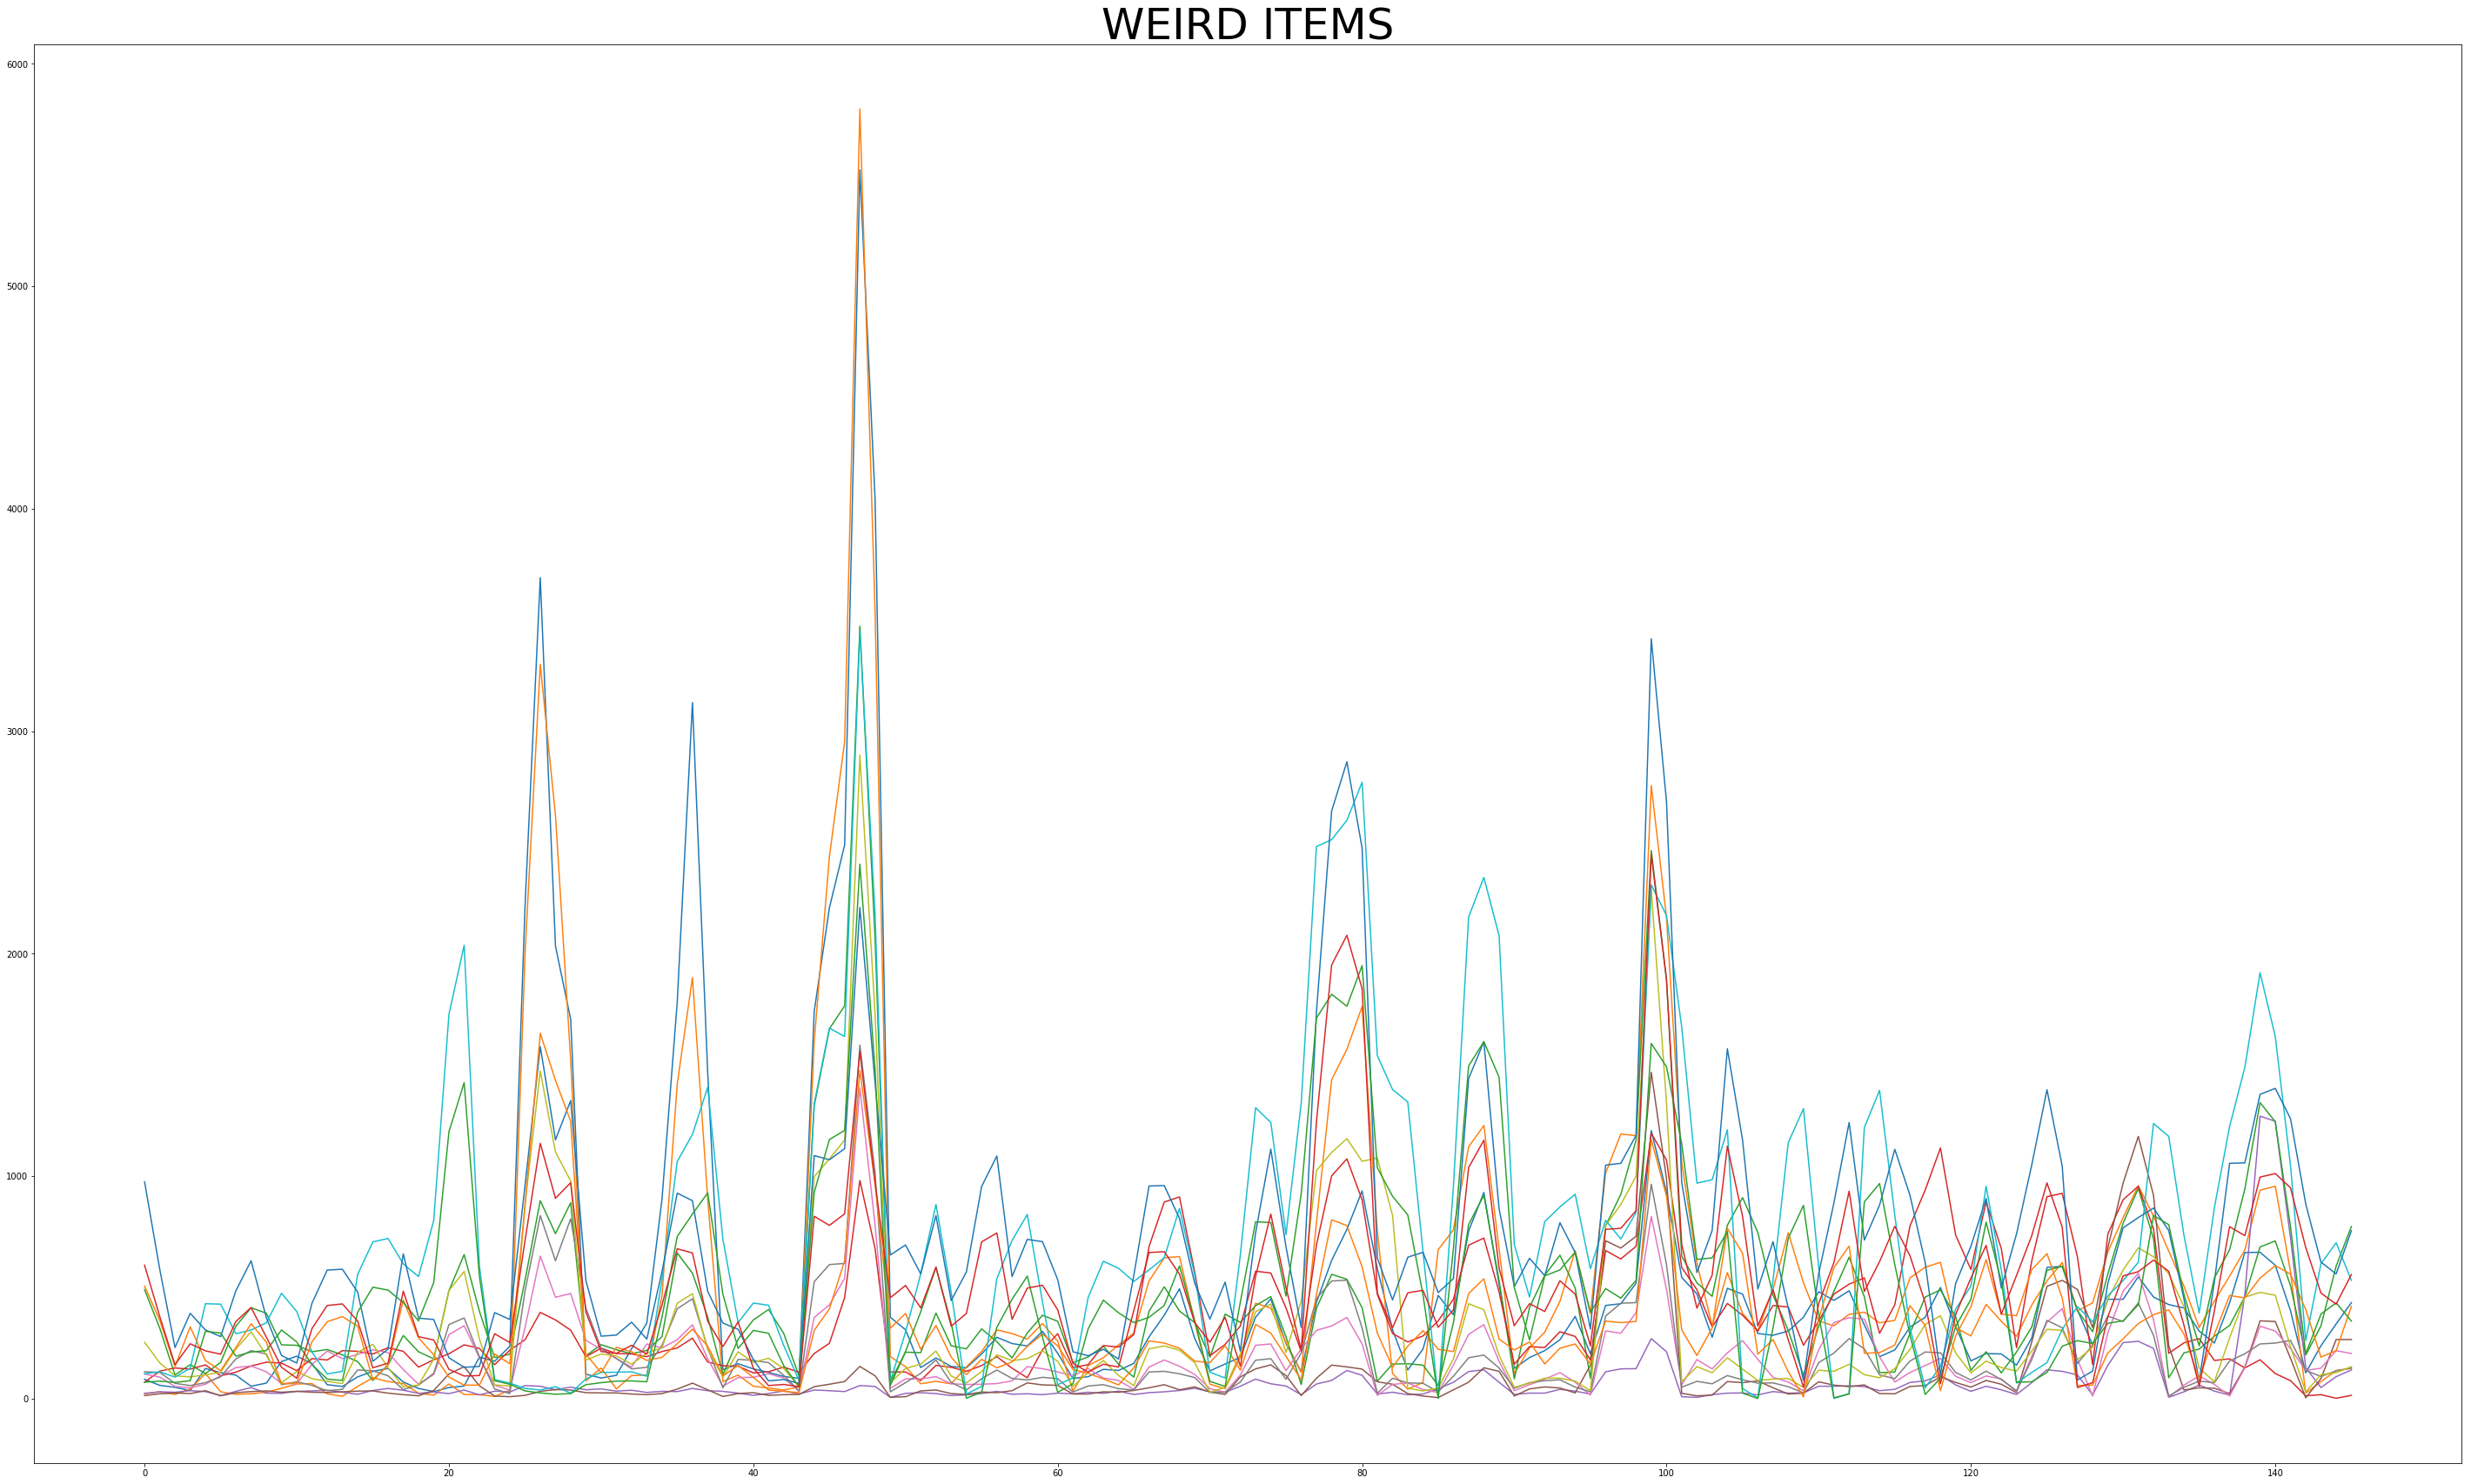

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 30))
plt.plot()
groupsData = cleansedData.groupby(groupKey)
for i in range(len(groupsData.groups)):
    onegroup = groupsData.get_group(list(groupsData.groups)[i])
    eachgroup = onegroup.reset_index(drop=True)
    if eachgroup.ITEM[0] in weirdList:
        plt.title('WEIRD ITEMS', fontsize=50)
        plt.plot(pd.Series(eachgroup.index), eachgroup.QTY)
# plt.ylabel('QTY')
# plt.xlabel('time')
plt.show()

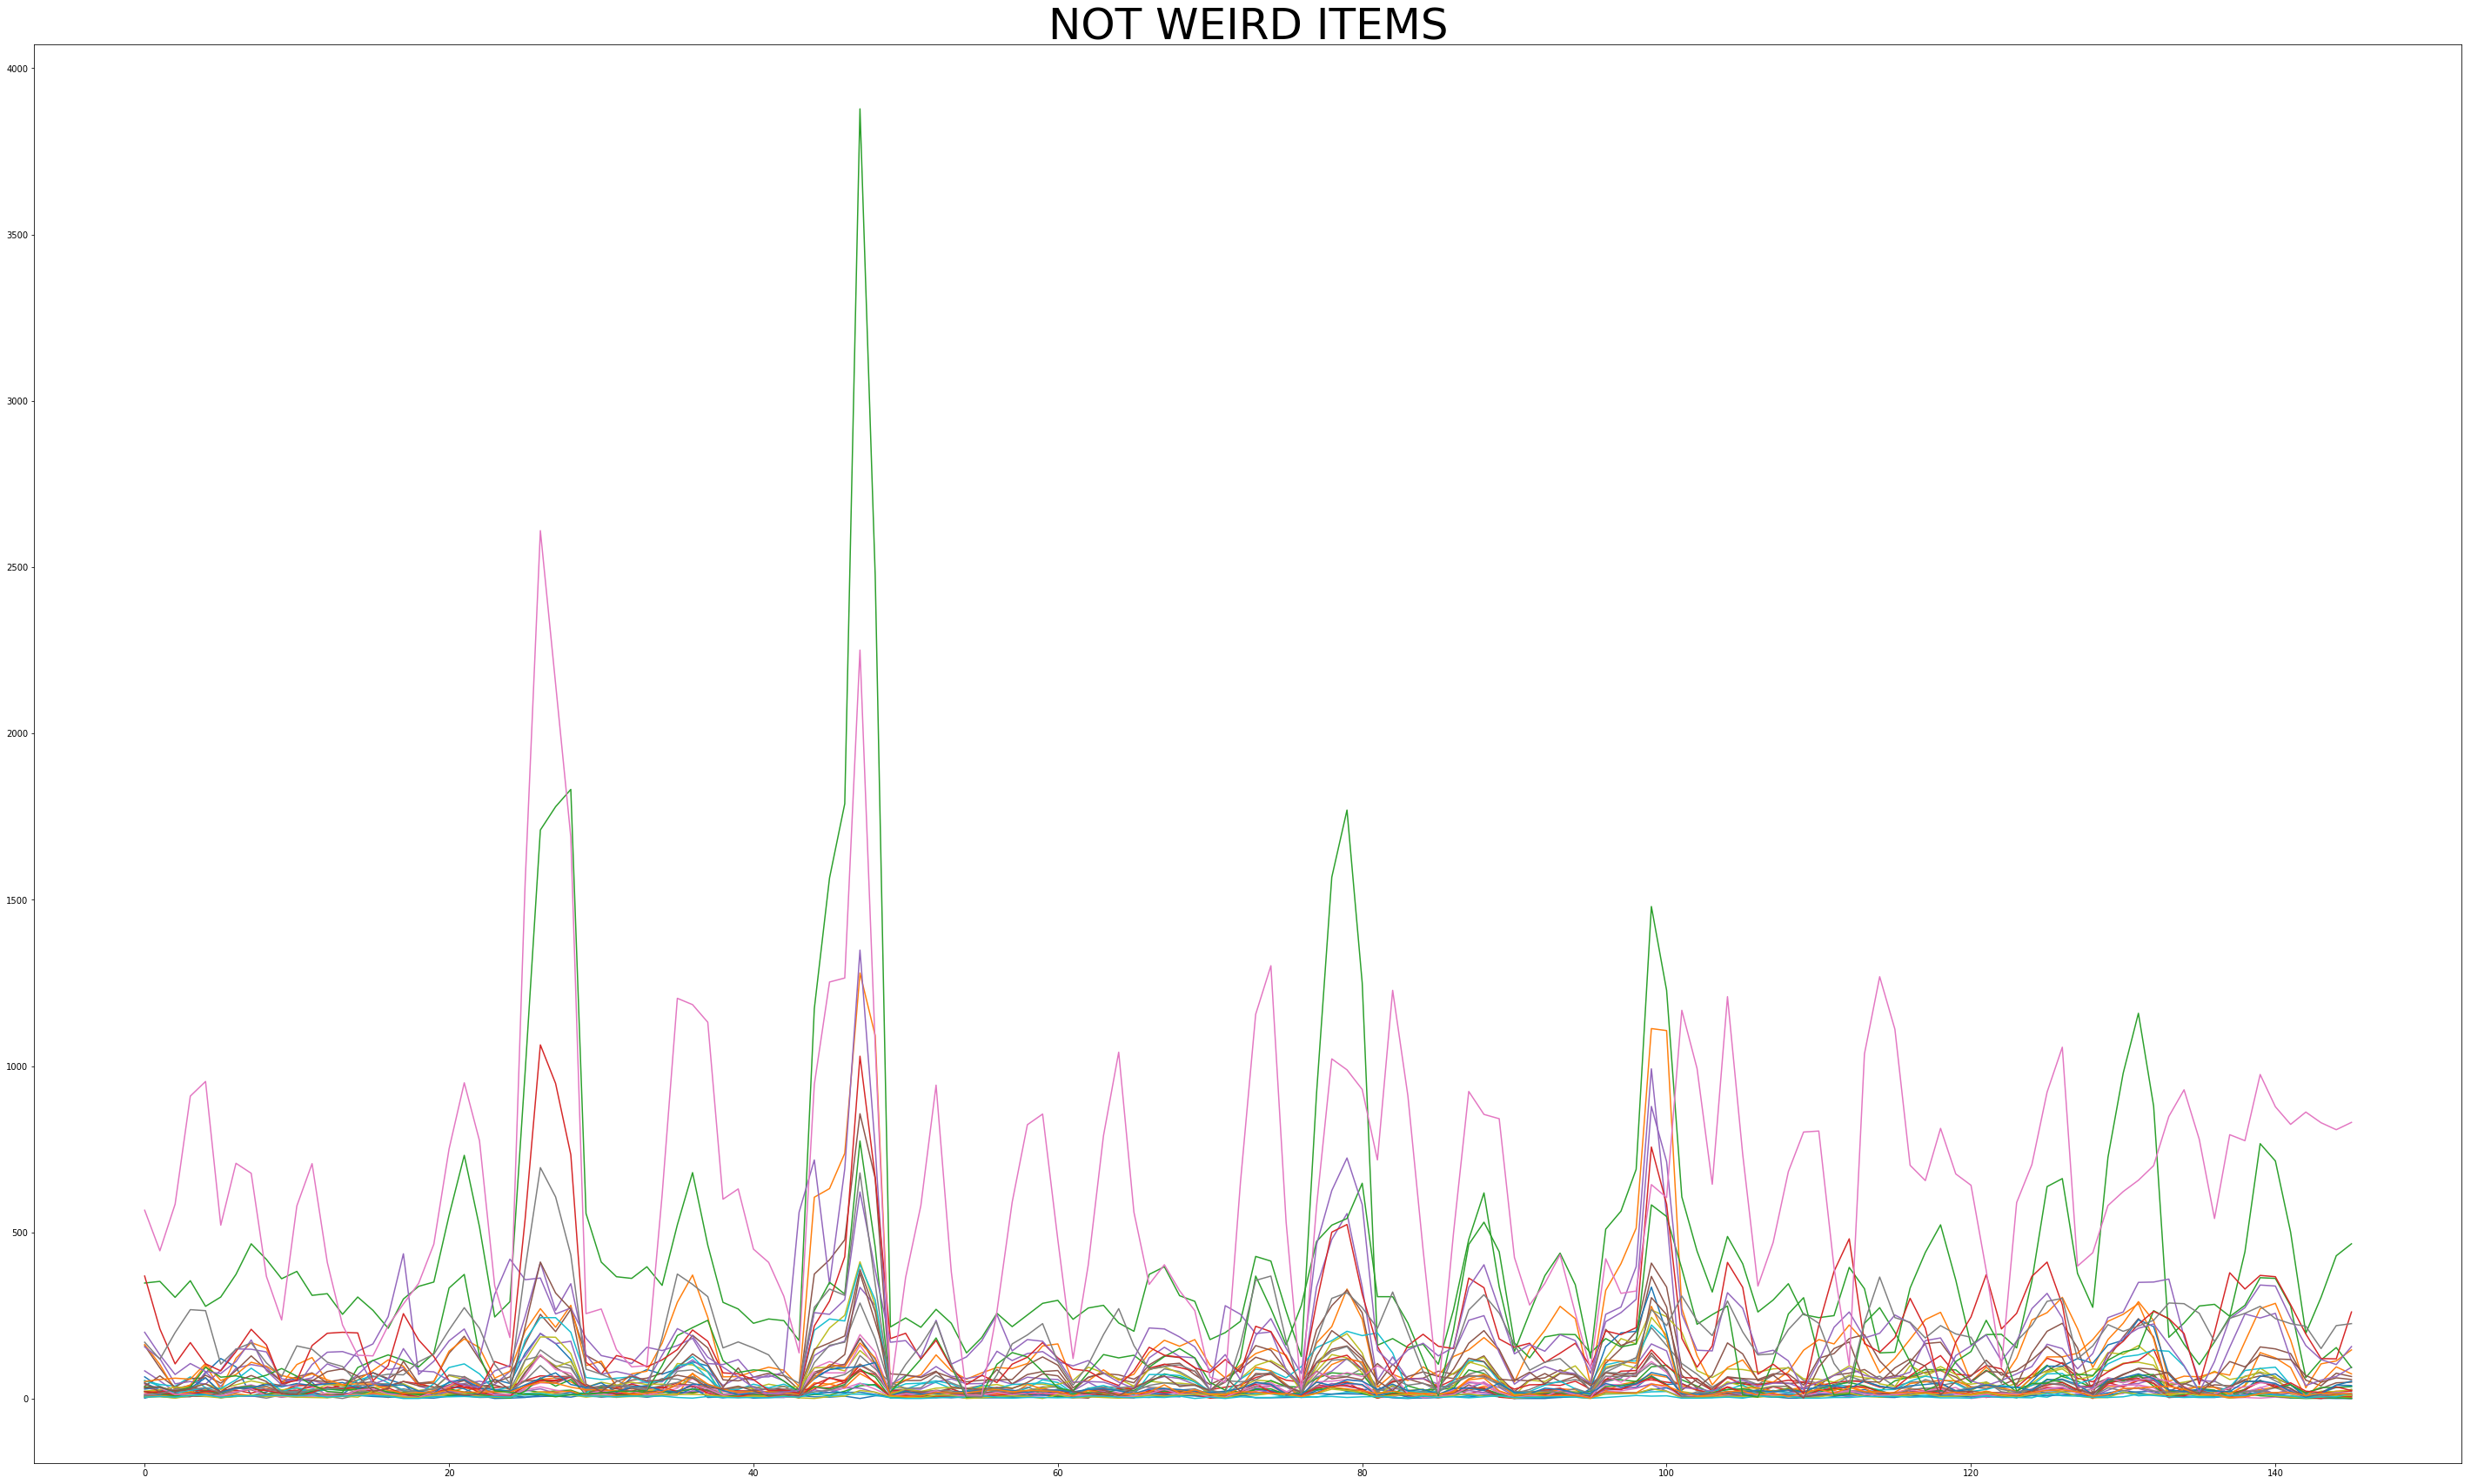

In [21]:
plt.figure(figsize=(50, 30))
plt.plot()
groupsData = cleansedData.groupby(groupKey)
for i in range(len(groupsData.groups)):
    onegroup = groupsData.get_group(list(groupsData.groups)[i])
    eachgroup = onegroup.reset_index(drop=True)
    if eachgroup.ITEM[0] not in weirdList:
        plt.title('NOT WEIRD ITEMS', fontsize=50)
        plt.plot(pd.Series(eachgroup.index), eachgroup.QTY)

plt.show()

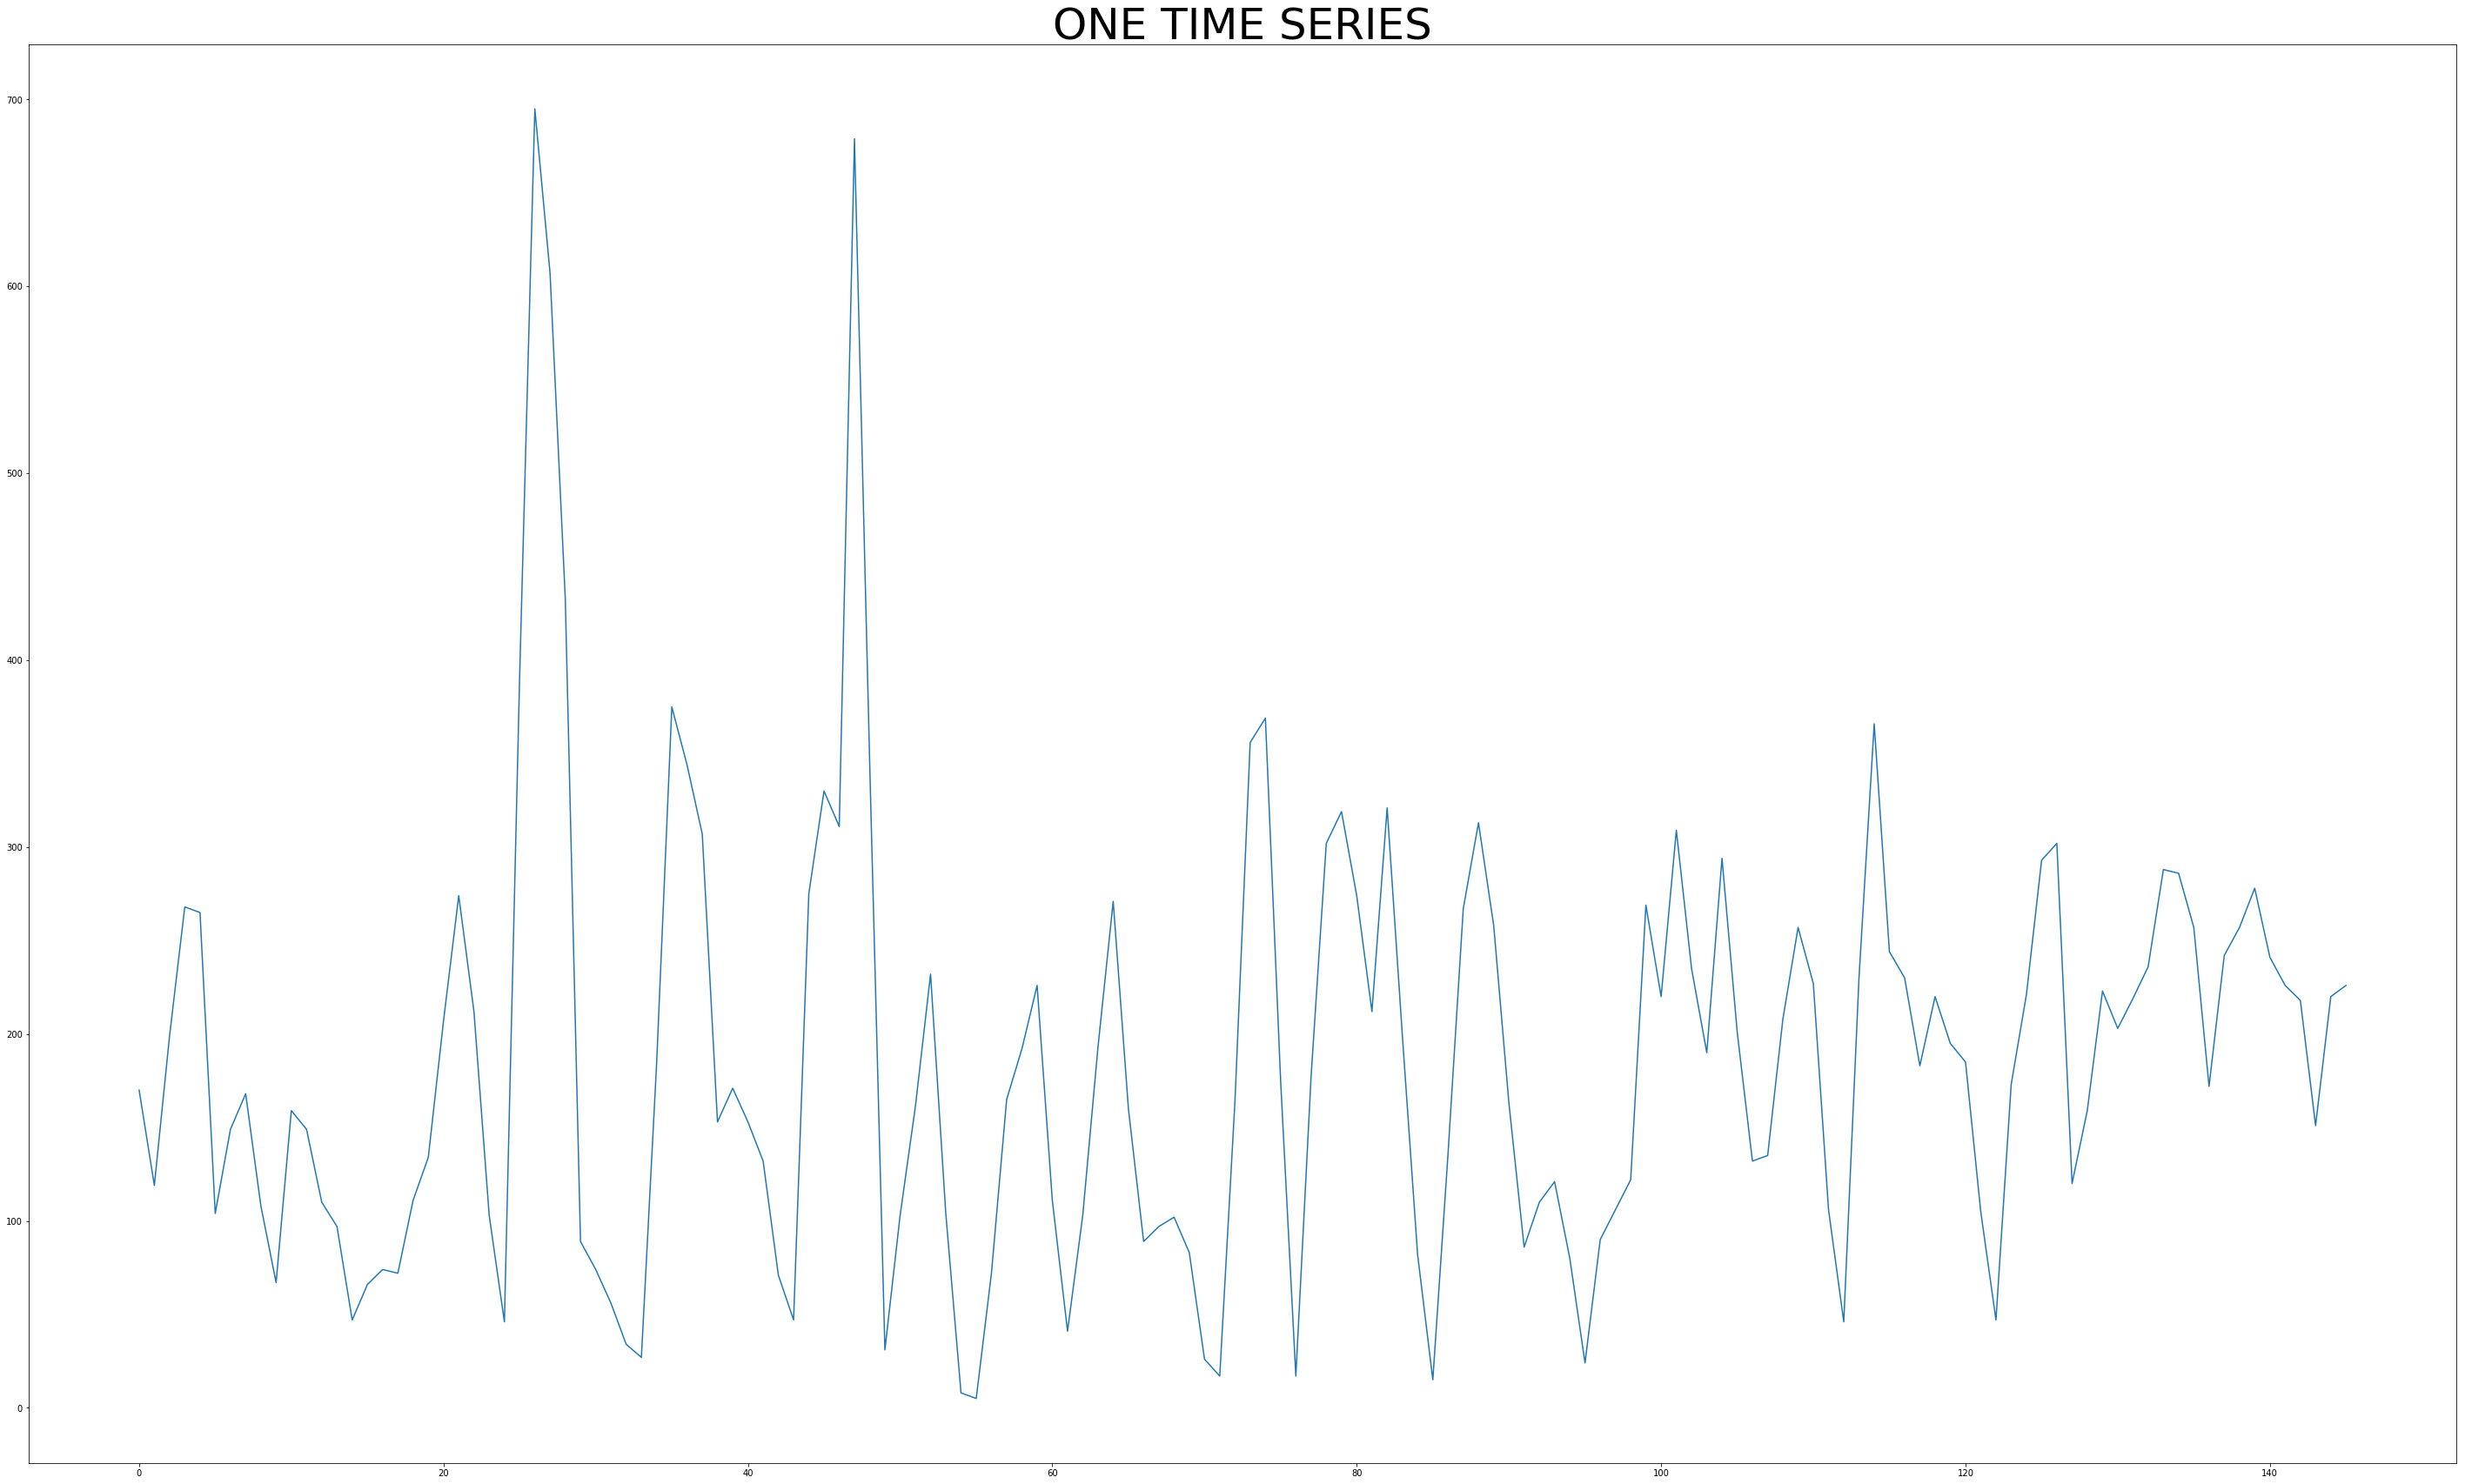

In [22]:
plt.figure(figsize=(50, 30))
plt.plot(pd.Series(eachgroup.index), eachgroup.QTY)
plt.title('ONE TIME SERIES', fontsize=50)
plt.show()

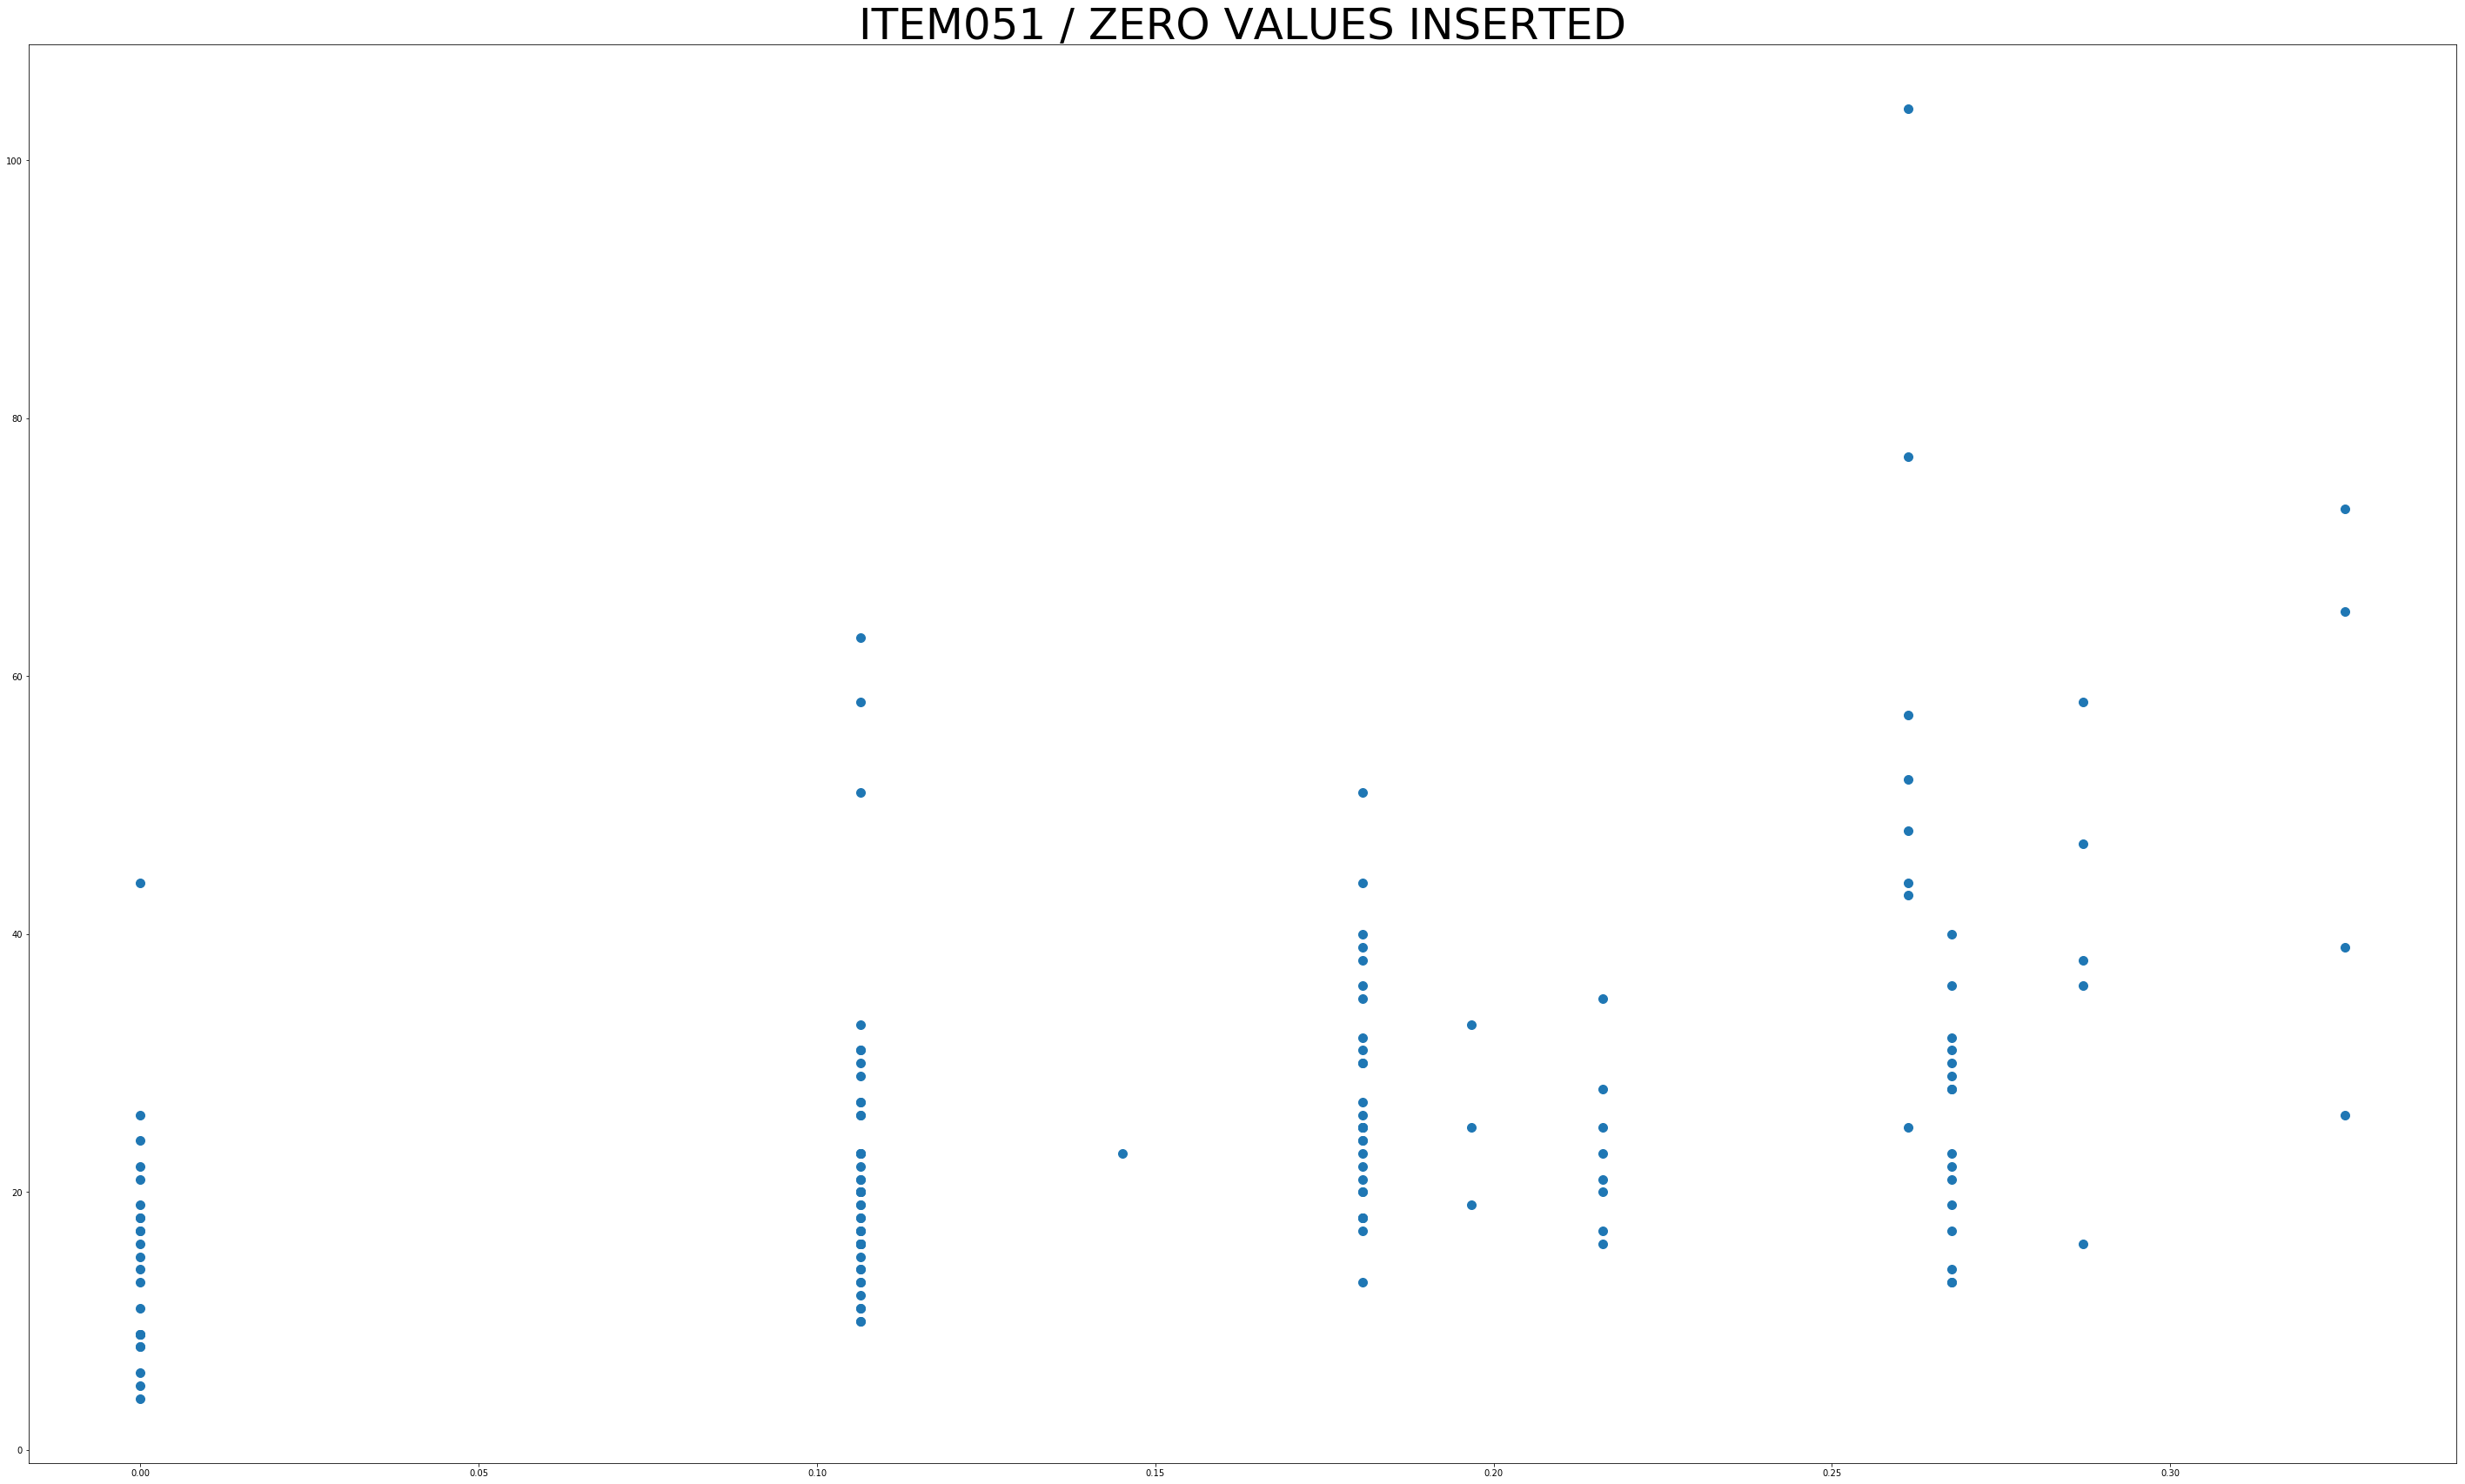

In [23]:
plt.figure(figsize=(50, 30))
plt.plot()
groupsData = cleansedData.groupby(groupKey)
for i in range(len(groupsData.groups)):
    onegroup = groupsData.get_group(list(groupsData.groups)[i])
    eachgroup = onegroup.reset_index(drop=True)
    if eachgroup.ITEM[0] == 'ITEM051':
#         plt.plot(pd.Series(eachgroup.index), eachgroup.QTY)
        plt.title('ITEM051 / ZERO VALUES INSERTED', fontsize=50)
        plt.scatter(eachgroup.PRO_PERCENT, eachgroup.QTY, s=100)

plt.show()

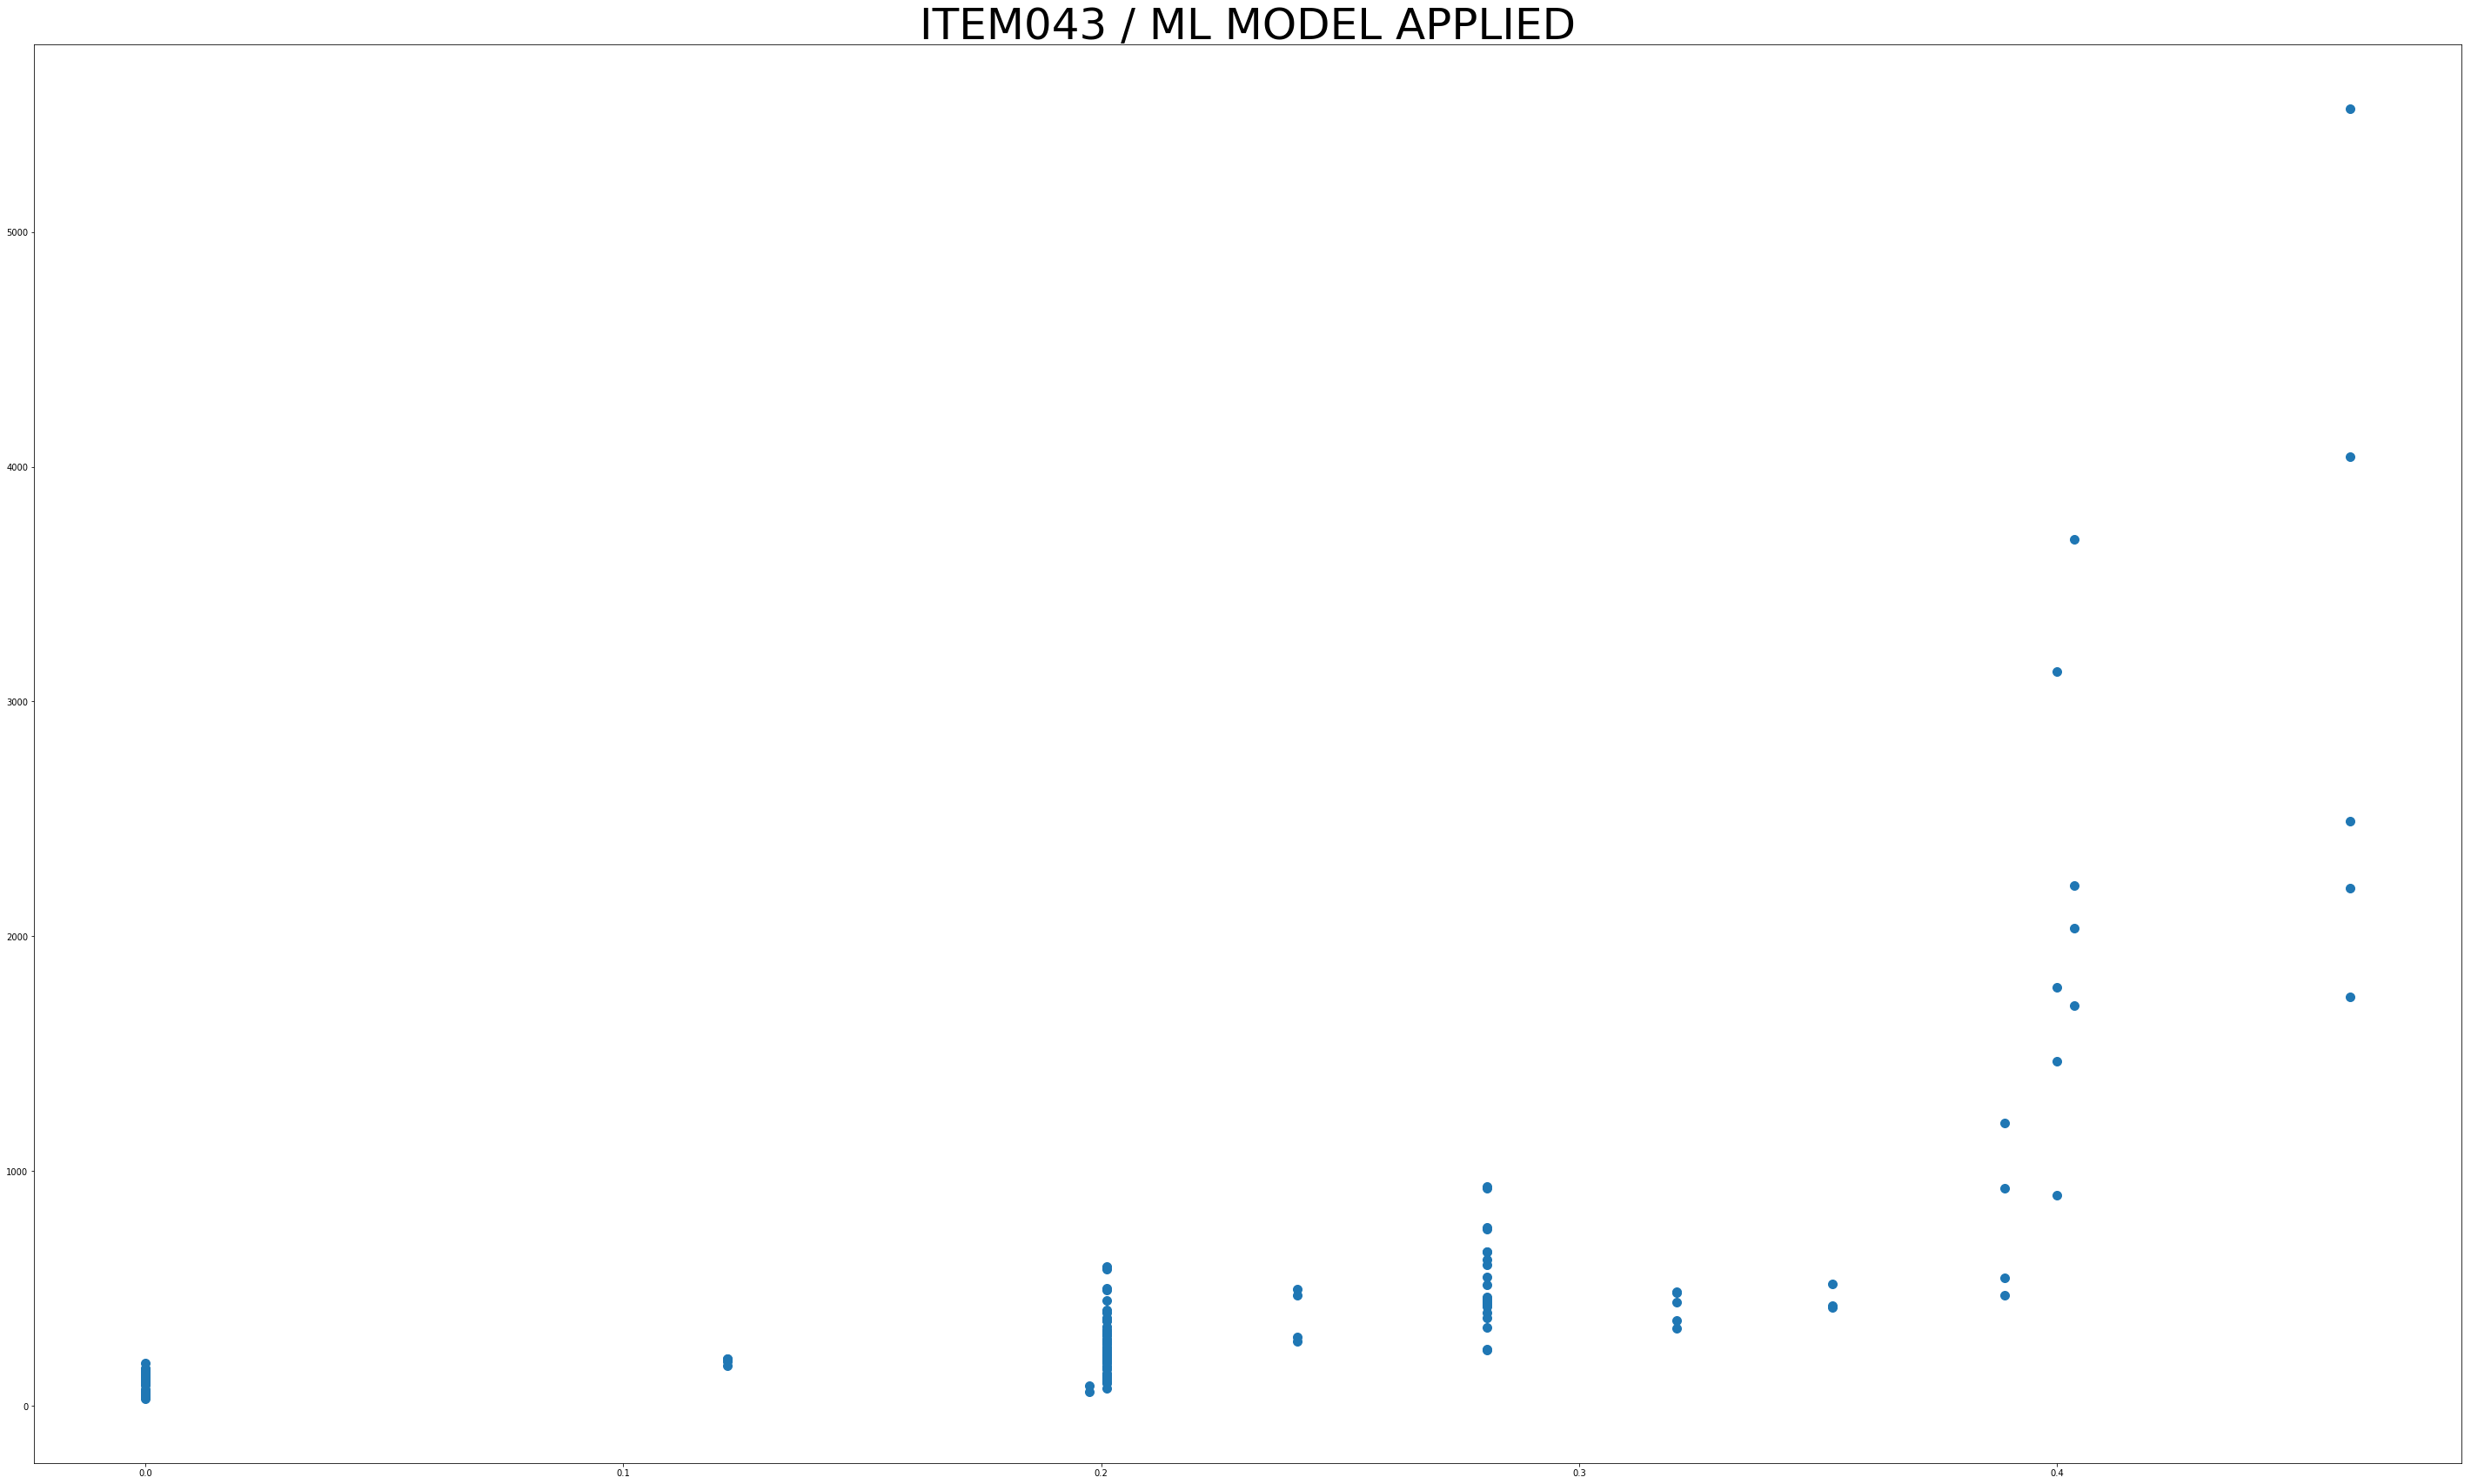

In [24]:
plt.figure(figsize=(50, 30))
plt.plot()
groupsData = cleansedData.groupby(groupKey)
for i in range(len(groupsData.groups)):
    onegroup = groupsData.get_group(list(groupsData.groups)[i])
    eachgroup = onegroup.reset_index(drop=True)
    if eachgroup.ITEM[0] == 'ITEM043':
#         plt.plot(pd.Series(eachgroup.index), eachgroup.QTY)
        plt.title('ITEM043 / ML MODEL APPLIED', fontsize=50)
        plt.scatter(eachgroup.PRO_PERCENT, eachgroup.QTY, s=100)

plt.show()